In [22]:
#numerico e dados
from tensorflow import keras
import numpy as np
from scipy.io import loadmat
from scipy.stats import skew, kurtosis

#plots
import matplotlib.pyplot as plt

#Caminho
from pathlib import Path

#minhas bibliotecas
from normalization import *
from net import *

Dados que serão utilizando para o modelo prever

In [6]:
#importando .mat sem os dados de PH
path = Path('BD/DADOSsemPH.mat')
mat = loadmat(path)

In [7]:
#Criando uma variável para cada divisão de dado
Xt = mat['Xtrain']
yt = mat['ytrain']

Xts = mat['Xtest']
yts = mat['ytest']

In [8]:
# Normalizando os dados
Xtn = Normalize(Xt)
ytn = Normalize(yt)

Xtsn = Normalize(Xts)
ytsn = Normalize(yts)

Carregando o modelo 

In [9]:
test_number = 4

In [10]:
#carregando a RNA
path_model = Path(f'./models/best_model{test_number}/model')
model = keras.models.load_model(path_model)

#carregando os hiperparametros
save_path = f'./models/best_model{test_number}'
hp_save_path = Path(save_path + '/hp')

#T, l, p, lbd, tau, hidden_neurons
with open(hp_save_path, 'rb') as f:
    T = np.load(f).astype('int')
    l = np.load(f).astype('float')
    p = np.load(f).astype('float')
    lbd = np.load(f).astype('float')
    tau = np.load(f).astype('float')
    neurons = np.load(f)


2022-08-02 11:02:09.738287: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-02 11:02:09.738427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 11:02:09.739095: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Transformando o modelo RNA densamente conectada para RNA MC Dropout 

In [11]:
network = net(tau, p, l, ytsn.shape[0], neurons) #criando o objeto MC com os mesmos hiperparâmetros
network.model = model #carregando o modelo no objeto MC

In [12]:
#fazendo uma previsão

network.MC_predict(Xtsn, ytsn, yts, T) 
y_pred = network.pred
y_inc = network.inc

y_inc_perc = (y_inc/y_pred).mean()*100

In [13]:
# Apresentando para fins de comparação de resultados
y_inc_perc

4.457938298583031

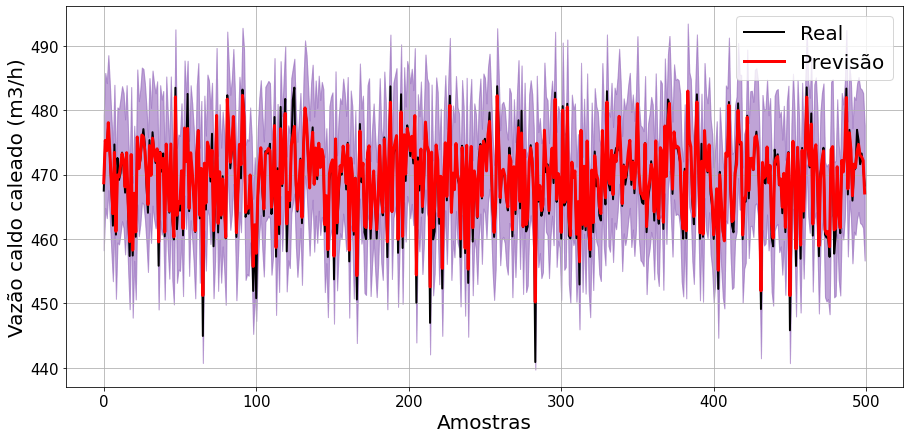

In [35]:
#figura da previsão com a adição da incerteza associada
fig2 = plt.figure(figsize=(15,7))

t = np.arange(y_pred.shape[0])

plt.plot(t[:500], yts[:500], color="black", label="Real", lw=2)
plt.plot(t[:500], y_pred[:500], color='red', label="Previsão", lw=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Amostras', fontsize=20)
plt.ylabel('Vazão caldo caleado (m3/h)', fontsize=20)

for shade in range(1,5):
  plt.fill_between(t[:500], (y_pred[:,0]+y_inc[:,0]/2)[:500], (y_pred[:,0]-y_inc[:,0]/2)[:500], alpha=0.2, color='C4')

plt.grid(True)
plt.legend(fontsize=20)

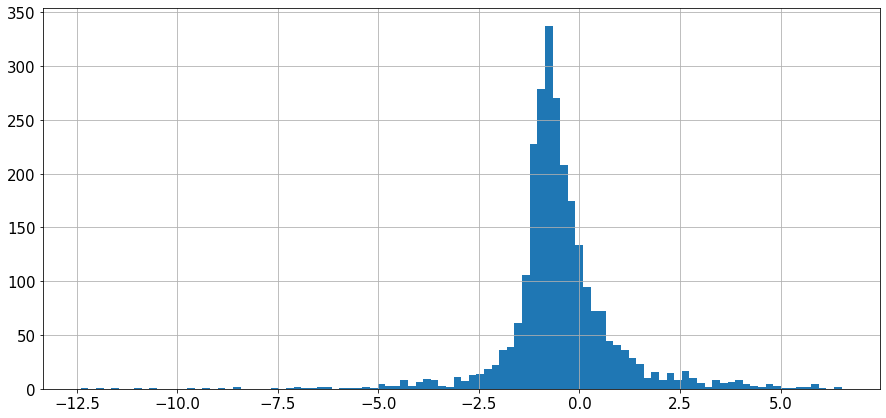

In [32]:
erro = yts - y_pred
plt.figure(figsize=(15,7))
plt.hist(erro,100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

In [25]:
print(f"skewness = {skew(erro)}")
print(f"kurtosis = {kurtosis(erro)}")

skewness = [-0.69651025]
kurtosis = [11.07370249]
